# Problem Statement

Much work on sentiment analysis has been done on short-form text data such as those derived from micro-blogging social media sites. Because of the succinct nature of these social media posts, it is perhaps easier to glean points of view than from longer pieces of text.
I would therefore like to perform sentiment parsing of long-form text in the form of book reviews.

I will use book reviews scraped from various websites including Goodreads stored on Kaggle as CSV files. The goal is to use different machine learning models to parse sentiment (either positive or negative) from each review. For this supervised classification problem, I will compare the performance of a Long Short Term Memory neural network (notebook c.) and Recurrent Neural Network (this notebook) to a Naive Bayes model (notebook b.)

In [1]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import spacy
import en_core_web_sm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [2]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews5.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)

# Preprocessing

I followed the same steps outlined in notebook c preprocessing the data in preparation for the LSTM neural network.

In [3]:
# Using spacy to tokenize and lemmatize not including pronouns
nlp = en_core_web_sm.load()

def lemmatize_text(text):
    """
    Takes a corpus of text and tokenizes it in addition to lemmatizing
    """
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [4]:
df['text'] = [lemmatize_text(sent) for sent in df['text']]

In [5]:
#converting the label column to an array in preparation to feed into neural network
x = df["text"]
y = df["label"].values
y

array([1, 1, 0, ..., 0, 0, 1])

In [6]:
#using Tensorflow's tokenizer to filter out special characters and digits
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [7]:
def get_sequence_of_tokens(corpus):
    """
    Takes a corpus of text as argument and returns its input size which will be used in creating the 
    neural network first layer.
    Also returns a vector representation of the text. 
    """
    #getting the input size to encode in the neural networks first layer
    total_words = len(tokenizer.word_index) + 1
    
    #converts texts into vector space 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [8]:
def generate_padded_sequences(input_sequences):
    """
    Takes vectorized representation of text as argument and pads sequences that are smaller 
    to the size of the longest sequence length. 
    """
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [9]:
# splits the vectorized representations of text and labels into test and training sizes
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.5, random_state=42)

Similar to the LSTM neural network, the simple RNN performs best with an even split between the test and training set.

# Setting up RNN


In [10]:
def build_model():
    """
    Builds layers of neural network.
    """
    opt = Adam(lr=1e-4)
    model = tf.keras.Sequential()
    #establishes first embedding layer with the shape of the total_words variable and a batch size of 128
    model.add(tf.keras.layers.Embedding(total_words, 128))
    #The next layer is bidirectional RNN
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)))
    model.add(tf.keras.layers.Dropout(0.1))
    #The last layer has sigmoid activation function to convert predictions to 0 - 1 format 
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

rnn_model = build_model()

In [11]:
#removes previous logs 
!rm -r /tmp/logs/

In [12]:
#saves the best performing model onto disk
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis_rnn.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_rnn = rnn_model.fit(x_train, y_train, epochs = 10, validation_split=0.1, 
                           callbacks = [tb_callback, checkpoint])

Epoch 1/10
 1/46 [..............................] - ETA: 0s - loss: 0.7083 - accuracy: 0.5625 - auc: 0.4107WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
46/46 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.4986 - auc: 0.4936
Epoch 00001: val_loss improved from inf to 0.69459, saving model to /tmp/sentiment_analysis_rnn.hdf5
46/46 [==============================] - 4s 97ms/step - loss: 0.7024 - accuracy: 0.4986 - auc: 0.4936 - val_loss: 0.6946 - val_accuracy: 0.4817 - val_auc: 0.5173
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.5918 - auc: 0.6357
Epoch 00002: val_loss did not improve from 0.69459
46/46 [==============================] - 4s 82ms/step - l

The simple RNN does not perform very well on this data set with fluctuating validation accuracy scores around the 5th and 8th epoch.

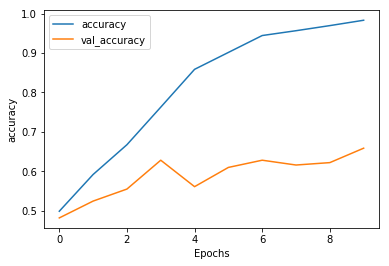

In [14]:
def plot_graphs(history, metric):
    """
    Takes a model and associated metric and plots performance over the specified epochs
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+ metric])
    plt.show()

plot_graphs(history_rnn, 'accuracy')

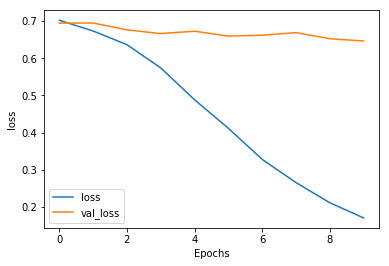

In [15]:
plot_graphs(history_rnn, 'loss')

In [16]:
results = rnn_model.evaluate(x_test, y_test)
print(results)

52/52 [==============================] - 1s 18ms/step - loss: 0.7308 - accuracy: 0.5741 - auc: 0.6186
[0.7307701706886292, 0.5740513801574707, 0.6185731887817383]


This model is the poorest performing out of the three tried out so far on both accuracy and auc. The layers of this model differ from the LSTM model in the absence of regularization layer which might diminish the model's ability to learn on sparse data.

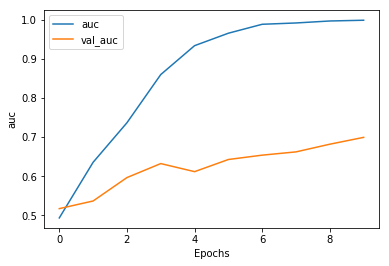

In [17]:
plot_graphs(history_rnn, 'auc')